In [15]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [16]:
#load in population grid info. 
PROJECT_ROOT = Path().absolute().parent
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
TEMP_DATA_DIR = DATA_DIR / 'temp'


population_info_raw=pd.read_csv(PROCESSED_DATA_DIR/'station_population_data.csv')
population_info_raw

,count,sum,nodata,grid_id,station_name,buffer_km,valid_pixels,nodata_pixels,total_pixels,prop_nodata,population_count
0,23,216.643463,87.0,21461,Aisa FM,20.0,23,87.0,110.0,0.790909,216.643463
1,58,700.665894,42.0,21291,Aisa FM,20.0,58,42.0,100.0,0.420000,700.665894
2,10,87.026184,111.0,21462,Aisa FM,20.0,10,111.0,121.0,0.917355,87.026184
3,80,864.314026,30.0,21292,Aisa FM,20.0,80,30.0,110.0,0.272727,864.314026
4,76,793.443115,45.0,21122,Aisa FM,20.0,76,45.0,121.0,0.371901,793.443115
...,...,...,...,...,...,...,...,...,...,...,...
9646,66,340.077698,55.0,12370,Dokolo FM,25.0,66,55.0,121.0,0.454545,340.077698
9647,51,233.072800,70.0,12200,Dokolo FM,25.0,51,70.0,121.0,0.578512,233.072800
9648,82,412.326538,39.0,12030,Dokolo FM,25.0,82,39.0,121.0,0.322314,412.326538
9649,56,270.777649,65.0,12201,Dokolo FM,25.0,56,65.0,121.0,0.537190,270.777649


             count          sum       nodata       grid_id    buffer_km  \
count  9651.000000  8708.000000  9651.000000   9651.000000  9651.000000   
mean     38.047042   302.580091    79.083100  14388.936172    23.048389   
std      21.657194   174.477512    21.854653   6034.514258     2.439239   
min       0.000000     3.802847     7.000000   6055.000000    20.000000   
25%      24.000000   200.612061    64.000000   9615.000000    20.000000   
50%      41.000000   283.750488    76.000000  11860.000000    25.000000   
75%      53.000000   381.442337    93.000000  20817.500000    25.000000   
max     114.000000  2563.534668   121.000000  26584.000000    25.000000   

       valid_pixels  nodata_pixels  total_pixels  prop_nodata  \
count   9651.000000    9651.000000   9651.000000  9651.000000   
mean      38.047042      79.083100    117.130142     0.675300   
std       21.657194      21.854653      5.815546     0.184109   
min        0.000000       7.000000    100.000000     0.057851   

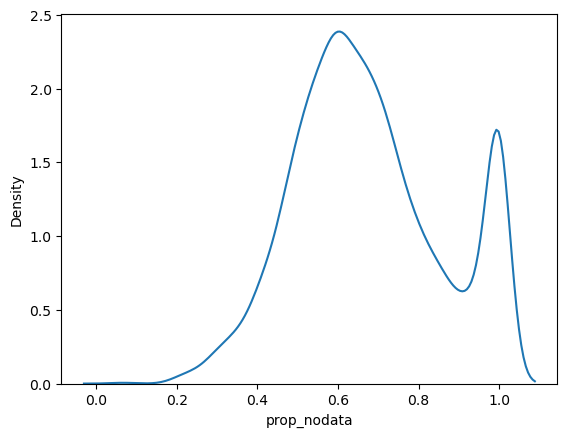

In [17]:
print(population_info_raw.describe())

sns.kdeplot(population_info_raw['prop_nodata'])
plt.show()

In [18]:
# open the gridded buffers (which has the polygons for each grid_id)
gridded_buffers_gdf=gpd.read_file(PROCESSED_DATA_DIR/'gridded_buffers_gdf.gpkg')
#select those grid cells where the proportion of nodata is lower than 0.8. Thus in at least one fifth of the pixels the cells should be inhabited. 
sampling_frame=population_info_raw

#how many cells left after excluding <=0.8? 
print(sampling_frame.groupby(['station_name','buffer_km']).size())

#let's take the 25km buffer. 
sampling_frame_25km=sampling_frame.loc[sampling_frame['buffer_km']==25.0]

station_name  buffer_km
Aisa FM       20.0         1263
              25.0         1971
Dokolo FM     20.0         1250
              25.0         1954
Dwanwana FM   20.0         1254
              25.0         1959
dtype: int64


In [19]:
len(sampling_frame_25km)
#select only the grid id and grid geos. 
sampling_frame_25km.grid_id.is_unique
#this is non-unique because 25 km for dokolo and dwawana overlap. 



False

0.10673011556764106
628


population_count
NaN    628
Name: count, dtype: int64

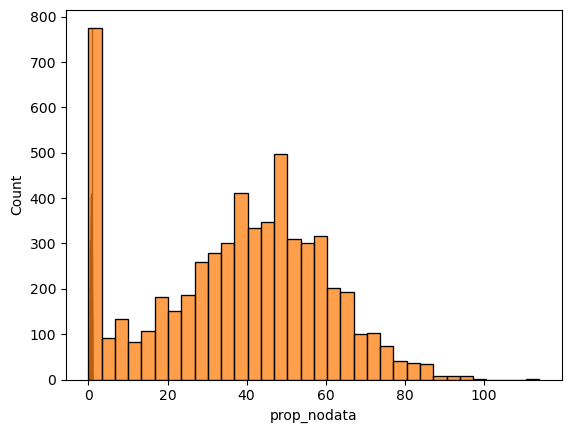

In [20]:
sns.histplot(data=sampling_frame_25km['prop_nodata'])
print(len(sampling_frame_25km.loc[sampling_frame_25km['prop_nodata']==1])/len(sampling_frame_25km))


sns.histplot(data=sampling_frame_25km['valid_pixels'])
sampling_frame_25km.loc[sampling_frame_25km['prop_nodata']>=0.9]

print(sampling_frame_25km['population_count'].isna().sum())

sampling_frame_25km.loc[sampling_frame_25km['population_count'].isna()].population_count.value_counts(dropna=False)


In [21]:
#replace nans with 0 in population count (these are uninhabited cells)
sampling_frame_25km.loc[:,'population_count']=sampling_frame_25km['population_count'].fillna(0)

print("number of duplicate grid_ids in the sampling frame by station?:", len(sampling_frame_25km[sampling_frame_25km.duplicated(subset=['grid_id', 'station_name'], keep=False)].sort_values(['grid_id', 'station_name'])))


number of duplicate grid_ids in the sampling frame by station?: 0


In [22]:
# Basic population statistics
print("Overall population statistics:")
print(sampling_frame_25km.groupby('station_name')['population_count'].describe())
print("total population per station in 25 km range",sampling_frame_25km.groupby('station_name')['population_count'].sum())

# Look at distribution
print("\nPopulation percentiles by station:")
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
print(sampling_frame_25km.groupby('station_name')['population_count'].quantile(np.array(percentiles)/100))

# Check how many grid cells would be excluded at different thresholds
thresholds = [0, 10, 50, 100, 200, 500]
for threshold in thresholds:
    n_excluded = len(sampling_frame_25km[sampling_frame_25km['population_count'] < threshold])
    pct_excluded = (n_excluded / len(sampling_frame_25km)) * 100
    print(f"\nThreshold {threshold}:")
    print(f"Would exclude {n_excluded} grid cells ({pct_excluded:.1f}%)")


Overall population statistics:
               count        mean         std  min         25%         50%  \
station_name                                                                
Aisa FM       1971.0  326.563624  264.290182  0.0   75.353741  327.627533   
Dokolo FM     1954.0  238.857083  132.879178  0.0  159.150047  251.574509   
Dwanwana FM   1959.0  239.280583  131.371973  0.0  161.413895  250.668274   

                     75%          max  
station_name                           
Aisa FM       497.997391  2563.534668  
Dokolo FM     320.685356  1024.882324  
Dwanwana FM   319.719238  1024.882324  
total population per station in 25 km range station_name
Aisa FM        643656.903162
Dokolo FM      466726.740782
Dwanwana FM    468750.661440
Name: population_count, dtype: float64

Population percentiles by station:
station_name      
Aisa FM       0.00       0.000000
              0.05       0.000000
              0.10       0.000000
              0.25      75.353741
         

In [23]:
#checking how big the population size needs to be in order to reasonably sample 12 households. 
# assuming:
interviews_needed = 12
response_rate = 0.8  # 80% of eligible households will respond
eligibility_rate = 0.8  # 80% of households are eligible (have kids? This is just an assumption)
persons_per_household = 4.9  # typical household size in Rural Uganda see DHS. 

# Calculate minimum population
min_households = interviews_needed / (response_rate * eligibility_rate)
min_population = min_households * persons_per_household

print(f"Minimum households needed: {min_households:.1f}")
print(f"Minimum population needed: {min_population:.1f}")

# Check how many grid cells meet this threshold
threshold = min_households
n_excluded = len(sampling_frame_25km[sampling_frame_25km['population_count'] < threshold])
pct_excluded = (n_excluded / len(sampling_frame_25km)) * 100
print(f"\nAt household threshold {threshold:.1f}:")
print(f"Would exclude {n_excluded} grid cells ({pct_excluded:.1f}%)")


Minimum households needed: 18.7
Minimum population needed: 91.9

At household threshold 18.7:
Would exclude 764 grid cells (13.0%)


In [24]:
###Let's stick to 20 or more households per cell to optimize data collection so that data team is only going to areas who are inhabited. 
sampling_frame_25km['household_count'] = sampling_frame_25km['population_count']/4.9
sampling_frame_25km = sampling_frame_25km[sampling_frame_25km['household_count'] >=20].copy()

sampling_frame_25km

C:\Users\linss\AppData\Local\Temp\ipykernel_28204\639151689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampling_frame_25km['household_count'] = sampling_frame_25km['population_count']/4.9


,count,sum,nodata,grid_id,station_name,buffer_km,valid_pixels,nodata_pixels,total_pixels,prop_nodata,population_count,household_count
1263,24,224.967194,97.0,22475,Aisa FM,25.0,24,97.0,121.0,0.801653,224.967194,45.911672
1264,59,626.496155,62.0,22305,Aisa FM,25.0,59,62.0,121.0,0.512397,626.496155,127.856358
1265,78,853.466797,43.0,22135,Aisa FM,25.0,78,43.0,121.0,0.355372,853.466797,174.176897
1266,70,734.965271,51.0,22476,Aisa FM,25.0,70,51.0,121.0,0.421488,734.965271,149.992912
1267,50,559.832336,71.0,22306,Aisa FM,25.0,50,71.0,121.0,0.586777,559.832336,114.251497
...,...,...,...,...,...,...,...,...,...,...,...,...
9646,66,340.077698,55.0,12370,Dokolo FM,25.0,66,55.0,121.0,0.454545,340.077698,69.403612
9647,51,233.072800,70.0,12200,Dokolo FM,25.0,51,70.0,121.0,0.578512,233.072800,47.565877
9648,82,412.326538,39.0,12030,Dokolo FM,25.0,82,39.0,121.0,0.322314,412.326538,84.148273
9649,56,270.777649,65.0,12201,Dokolo FM,25.0,56,65.0,121.0,0.537190,270.777649,55.260745


In [25]:
def pps_sample_station(
    df: pd.DataFrame,
    station_name: str,
    n_clusters: int = 35,
    interviews_per_cluster=12,
    random_seed: int = 42
    
) -> pd.DataFrame:
    """
    Perform PPS sampling for a specific radio station using population count as size measure,
    ensuring no clusters are selected multiple times.
    
    Parameters:
    -----------
    df : DataFrame with sampling frame data
    station_name : Name of the radio station to sample for
    n_clusters : Number of clusters to select
    random_seed : Random seed for reproducibility
    
    Returns:
    --------
    DataFrame with selected clusters and their weights
    """
    # Set random seed
    np.random.seed(random_seed)
    
    # Filter for specific station and copy to avoid modifying original
    station_df = df[df['station_name'] == station_name].copy()
    
    # Ensure we have enough clusters to sample
    if len(station_df) < n_clusters:
        raise ValueError(f"Not enough clusters available. Need {n_clusters} but only have {len(station_df)}")
    
    # Use numpy's choice function to sample without replacement
    total_hhpop = station_df['household_count'].sum()
    probabilities = station_df['household_count'] / total_hhpop
    
    selected_indices = np.random.choice(
        station_df.index,
        size=n_clusters,
        replace=False,  # This ensures no duplicates
        p=probabilities
    )
    
    # Get selected clusters
    selected_clusters = station_df.loc[selected_indices].copy()
    
    # Calculate selection probabilities and weights
    selected_clusters['selection_prob'] = selected_clusters['household_count'] / total_hhpop
    selected_clusters['sampling_weight'] = 1 / selected_clusters['selection_prob']
    
    # Add sample size and total population info
    selected_clusters['interviews_per_cluster'] = interviews_per_cluster
    selected_clusters['total_population_covered_hhs'] = total_hhpop
    
    return selected_clusters




In [26]:
###draw sample
dfs = []
for station in sampling_frame_25km.station_name.unique(): 
    print(station)
    print()
    
    # Get all 70 clusters with PPS
    sample = pps_sample_station(sampling_frame_25km, station_name=station, n_clusters=70)
    
    # Add main/replacement designation just assign to main and replacement randomly.
    # Create balanced array of 35 main and 35 replacement
    cluster_types = np.array(['main']*35 + ['replacement']*35)
    np.random.shuffle(cluster_types)  # randomly shuffle the array
    sample['cluster_type'] = cluster_types # then assign that randomly shuffled array to a column
    
    print(sample.head())
    dfs.append(sample)
    
all_sampled_clusters = pd.concat(dfs)

# verify check
print("\nFinal counts by station and type:")
print(all_sampled_clusters.groupby(['station_name', 'cluster_type']).size())

print(all_sampled_clusters)


Aisa FM

      count         sum  nodata  grid_id station_name  buffer_km  \
1938     43  363.440582    67.0    24354      Aisa FM       25.0   
3051     82  661.170654    39.0    23364      Aisa FM       25.0   
2562     54  504.532043    56.0    18931      Aisa FM       25.0   
2300     71  546.130737    50.0    23184      Aisa FM       25.0   
1475     88  756.206604    22.0    19768      Aisa FM       25.0   

      valid_pixels  nodata_pixels  total_pixels  prop_nodata  \
1938            43           67.0         110.0     0.609091   
3051            82           39.0         121.0     0.322314   
2562            54           56.0         110.0     0.509091   
2300            71           50.0         121.0     0.413223   
1475            88           22.0         110.0     0.200000   

      population_count  household_count  selection_prob  sampling_weight  \
1938        363.440582        74.171547        0.000571      1749.938804   
3051        661.170654       134.932787      

In [27]:
#check check 

print("Average households per cluster:", sampling_frame_25km['household_count'].mean())
print("Min households:", sampling_frame_25km['household_count'].min())
print("Max households:", sampling_frame_25km['household_count'].max())

# Verify PPS weights
print("\nSampling weight statistics:")
print(all_sampled_clusters['sampling_weight'].describe())

print(all_sampled_clusters.grid_id.is_unique)


print("number of duplicate grid_ids in all sampled clusters by station?:", len(all_sampled_clusters[all_sampled_clusters.duplicated(subset=['grid_id', 'station_name'], keep=False)].sort_values(['grid_id', 'station_name'])))

# #non unique grid ids what is happening? 

# _duplicate_gridids =all_sampled_clusters[all_sampled_clusters.grid_id.duplicated(keep=False)].sort_values(['grid_id', 'station_name'])

# _duplicate_gridids

Average households per cluster: 67.08955235960012
Min households: 20.04641163105867
Max households: 523.1703404017857

Sampling weight statistics:
count     210.000000
mean     1606.024604
std       750.077935
min       357.720612
25%      1136.791211
50%      1432.051190
75%      1792.903900
max      4604.045666
Name: sampling_weight, dtype: float64
False
number of duplicate grid_ids in all sampled clusters by station?: 0


In [28]:
#merge the sample with the.geo stuff so we know where these locations are. 
#grid_id_geo has non unique grid ids (the buffers for 20 km overlaps with the 25km buffer)
grid_id_geo_gdf=gridded_buffers_gdf[['grid_id', 'geometry']].drop_duplicates(subset='grid_id')




# Convert to geodataframe with left merge to maintain all sampled clusters
sampled_clusters_gdf = all_sampled_clusters.merge(
    grid_id_geo_gdf[['grid_id', 'geometry']], 
    on='grid_id',
    how='left'
)

# Convert to GeoDataFrame
sampled_clusters_gdf = gpd.GeoDataFrame(
    sampled_clusters_gdf, 
    geometry='geometry',
    crs=grid_id_geo_gdf.crs  # maintain the same CRS as your original geodataframe
)

#add the centord lat lon. 



In [ ]:
sampled_clusters_gdf
#add the centroid to the map. 



,count,sum,nodata,grid_id,station_name,buffer_km,valid_pixels,nodata_pixels,total_pixels,prop_nodata,population_count,household_count,selection_prob,sampling_weight,interviews_per_cluster,total_population_covered_hhs,cluster_type,geometry
0,43,363.440582,67.0,24354,Aisa FM,25.0,43,67.0,110.0,0.609091,363.440582,74.171547,0.000571,1749.938804,12,129795.668939,replacement,"POLYGON ((33.91495 1.31965, 33.91495 1.32869, ..."
1,82,661.170654,39.0,23364,Aisa FM,25.0,82,39.0,121.0,0.322314,661.170654,134.932787,0.001040,961.928322,12,129795.668939,main,"POLYGON ((33.86112 1.59105, 33.86112 1.60010, ..."
2,54,504.532043,56.0,18931,Aisa FM,25.0,54,56.0,110.0,0.509091,504.532043,102.965723,0.000793,1260.571625,12,129795.668939,replacement,"POLYGON ((33.62736 1.47353, 33.62736 1.48258, ..."
3,71,546.130737,50.0,23184,Aisa FM,25.0,71,50.0,121.0,0.413223,546.130737,111.455253,0.000859,1164.554079,12,129795.668939,main,"POLYGON ((33.85210 1.50059, 33.85210 1.50964, ..."
4,88,756.206604,22.0,19768,Aisa FM,25.0,88,22.0,110.0,0.200000,756.206604,154.327878,0.001189,841.038381,12,129795.668939,replacement,"POLYGON ((33.67227 1.35591, 33.67228 1.36496, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,41,313.820129,59.0,10121,Dokolo FM,25.0,41,59.0,100.0,0.590000,313.820129,64.044924,0.000685,1460.464166,12,93535.317036,main,"POLYGON ((33.15993 1.74503, 33.15993 1.75408, ..."
206,56,262.665405,54.0,12704,Dokolo FM,25.0,56,54.0,110.0,0.490909,262.665405,53.605185,0.000573,1744.893101,12,93535.317036,replacement,"POLYGON ((33.29484 2.04357, 33.29485 2.05262, ..."
207,47,312.007233,74.0,10465,Dokolo FM,25.0,47,74.0,121.0,0.611570,312.007233,63.674945,0.000681,1468.950093,12,93535.317036,main,"POLYGON ((33.17792 1.78122, 33.17792 1.79026, ..."
208,54,292.693024,67.0,11352,Dokolo FM,25.0,54,67.0,121.0,0.553719,292.693024,59.733270,0.000639,1565.883080,12,93535.317036,replacement,"POLYGON ((33.22292 2.11596, 33.22292 2.12500, ..."


In [ ]:
# Project to local CRS for centroid calculation
sampled_clusters_projected = sampled_clusters_gdf.to_crs(epsg=21097)  # UTM zone for Uganda

# Calculate centroids
sampled_clusters_gdf['centroid_lon'] = sampled_clusters_projected.geometry.centroid.to_crs(sampled_clusters_gdf.crs).x
sampled_clusters_gdf['centroid_lat'] = sampled_clusters_projected.geometry.centroid.to_crs(sampled_clusters_gdf.crs).y

# Save to file
sampled_clusters_gdf.to_file(PROCESSED_DATA_DIR / 'sampled_clusters.gpkg')



C:\Users\linss\AppData\Local\Temp\ipykernel_28204\971619071.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sampled_clusters_gdf['centroid_lon'] = sampled_clusters_gdf.geometry.centroid.x
C:\Users\linss\AppData\Local\Temp\ipykernel_28204\971619071.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sampled_clusters_gdf['centroid_lat'] = sampled_clusters_gdf.geometry.centroid.y


ValueError: Invalid field type <class 'tuple'>

In [ ]:
station_buffers_gdf=gpd.read_file(PROCESSED_DATA_DIR / 'station_buffers.gpkg')
station_loc_gdf=gpd.read_file(PROCESSED_DATA_DIR / 'station_loc.gpkg')



In [ ]:
# Create map
m = folium.Map(location=[station_loc_gdf.geometry.y.mean(), station_loc_gdf.geometry.x.mean()], 
               zoom_start=10)

# Create legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 200px; height: auto;
            background-color: white;
            border: 2px solid grey;
            z-index: 1000;
            padding: 10px;
            font-size: 14px;
            ">
<p><strong>Radio Stations</strong></p>
"""

# Add each station to the legend with its color
for idx, row in station_loc_gdf.iterrows():
    legend_html += f"""
    <p>
        <i class="fa fa-circle" style="color:{row['color']}"></i>
        {row['station_name']}
    </p>
    """
legend_html += "<p><strong>Assumed Coverage Ranges</strong></p>"
legend_html += """
<p>― 20km (solid line, highest opacity)</p>
<p>-- 25km (dashed line)</p>
<p>― ― 40km (long dashes)</p>
<p>... 60km (dotted line, lowest opacity)</p>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

# Create a Feature Group for each radio station's buffers
station_buffer_groups = {}
for station in station_loc_gdf['station_name'].unique():
    station_buffer_groups[station] = folium.FeatureGroup(name=f'Ranges {station}')

# Sort buffers from largest to smallest for proper layering
station_buffers_gdf = station_buffers_gdf.sort_values('buffer_km', ascending=False)

# Add buffers with different styles
for idx, row in station_buffers_gdf.iterrows():
    station_name = row['station_name']
    
    # Define style based on buffer size
    if row['buffer_km'] == 20:
        style = {
            'fillOpacity': 0.4, 
            'dashArray': None, 
            'weight': 2
        }
    elif row['buffer_km'] == 25:
        style = {
            'fillOpacity': 0.3, 
            'dashArray': '5,5', 
            'weight': 2
        }
    elif row['buffer_km'] == 40:
        style = {
            'fillOpacity': 0.2, 
            'dashArray': '10,10', 
            'weight': 2
        }
    else:  # 60km
        style = {
            'fillOpacity': 0.1, 
            'dashArray': '2,8', 
            'weight': 2
        }

    folium.GeoJson(
        row.geometry,
        style_function=lambda x, color=row['original_color'], style=style: {
            'fillColor': color,
            'color': color,
            'fillOpacity': style['fillOpacity'],
            'dashArray': style['dashArray'],
            'weight': style['weight']
        },
        highlight_function=lambda x: {
            'weight': 3,
            'fillOpacity': style['fillOpacity'] + 0.2
        },
        tooltip=f"{station_name} - {row['buffer_km']}km range",
        popup=folium.Popup(
            f"""
            <div style='width: 200px'>
                <b>{station_name}</b><br>
                Coverage Range: {row['buffer_km']} km<br>
            </div>
            """,
            max_width=300
        )
    ).add_to(station_buffer_groups[station_name])

# Add station points
for idx, row in station_loc_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['station_name'],
        tooltip=f"Click to see {row['station_name']} location",
        icon=folium.Icon(
            color='white',  
            icon_color=row['color'],
            icon='radio', 
            prefix='fa'
        )
    ).add_to(m)

# Add all buffer groups to the map
for group in station_buffer_groups.values():
    group.add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)


In [ ]:
m

In [ ]:
m